<a href="https://colab.research.google.com/github/nooyeat/Instacart_project/blob/main/Instacart_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 초기 가설 설정

In [ ]:
import pandas as pd
import os
import random
import numpy as np
import tensorflow as tf
import re

aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

product_features = products

products_reordered_mean = train.groupby(['product_id'])['reordered'].mean().to_frame('product_reorder_rate').reset_index()

#각 제품의 재구매율 피처에 추가
product_features = product_features.merge(products_reordered_mean, on = 'product_id')

health_keywords = ['low fat', 'gluten free', 'sugar free', 'organic', 'diet', 'zero sugar']

pattern_list = [
r'low[\s\-]?fat',
r'gluten[\s\-]?free',
r'sugar[\s\-]?free',
r'zero[\s\-]?sugar',
r'\bdiet\b',
r'\borganic\b'
]

combined_pattern = re.compile('|'.join(pattern_list), re.IGNORECASE)

product_features['healthcare'] = product_features['product_name'].apply(
lambda x: int(bool(combined_pattern.search(str(x))))
)

# 제품별 재구매율 계산
prod_reorder = train.groupby('product_id')['reordered'].mean().reset_index()
prod_reorder.columns = ['product_id', 'product_reorder_rate']

# 제품 정보와 결합하여 카테고리 부여
prod_cat = products.merge(prod_reorder, on='product_id', how='left')

# department 기준
dept_reorder = prod_cat.groupby('department_id')['product_reorder_rate'].mean().reset_index()
dept_reorder.columns = ['department_id', 'department_reorder_rate']

# aisle 기준
aisle_reorder = prod_cat.groupby('aisle_id')['product_reorder_rate'].mean().reset_index()
aisle_reorder.columns = ['aisle_id', 'aisle_reorder_rate']

# product_id 단위로 피처 부여
product_features = product_features.merge(dept_reorder, on='department_id', how='left')
product_features = product_features.merge(aisle_reorder, on='aisle_id', how='left')

train_data = train.merge(product_features, on='product_id', how='left')
train_data = train_data[['order_id', 'product_id', 'healthcare', 'add_to_cart_order', 'product_reorder_rate', 'department_reorder_rate', 'aisle_reorder_rate', 'reordered']]

In [ ]:
#데이터 전처리 - null값 제거, order_id, product_id 컬럼 제거

original_data = train_data.copy()
original_data.dropna(inplace = True)
original_data.drop(columns=['order_id', 'product_id'], inplace=True)

In [ ]:
# add_to_cart_order MinMax스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_data[["add_to_cart_order"]])
original_data['add_to_cart_order'] = original_data_scaled

In [ ]:
#데이터 분할
from sklearn.model_selection import train_test_split
X = original_data.drop('reordered', axis=1)
y = original_data['reordered']

# 1차로 Train(80%)과 Test(20%)로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2차로 Train을 다시 Train(75%)과 Validation(25%)로 나누기 → 전체 비율 6:2:2 맞춤
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# 최종 데이터 크기 확인
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Validation: {y_val.shape}, Test: {y_test.shape}")

Train: (830769, 5), Validation: (276924, 5), Test: (276924, 5)
Train: (830769,), Validation: (276924,), Test: (276924,)


## 모델 설계

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

# 시드 고정
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)


# 모델 설계
model = keras.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    BatchNormalization(),

    layers.Dense(128, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    BatchNormalization(),

    layers.Dense(32, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['acc']
)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    batch_size=64, callbacks=[early_stopping], verbose=1)

Epoch 1/100
12981/12981 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - acc: 0.6617 - loss: 0.6152 - val_acc: 0.6683 - val_loss: 0.6018
Epoch 2/100
12981/12981 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - acc: 0.6677 - loss: 0.6049 - val_acc: 0.6693 - val_loss: 0.6011
Epoch 3/100
12981/12981 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - acc: 0.6681 - loss: 0.6038 - val_acc: 0.6690 - val_loss: 0.6012
Epoch 4/100
12981/12981 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - acc: 0.6683 - loss: 0.6034 - val_acc: 0.6691 - val_loss: 0.6013
Epoch 5/100
12981/12981 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - acc: 0.6684 - loss: 0.6030 - val_acc: 0.6690 - val_loss: 0.6013
Epoch 6/100
12981/12981 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - acc: 0.6683 - loss: 0.6028 - val_acc: 0.6689 - val_loss: 0.6009


## 모델 평가

In [ ]:
from sklearn.metrics import classification_report
pred_prob = model.predict(X_test)
pred = (pred_prob>0.5).astype(int)
score = classification_report(y_test, pred, output_dict=True)
pd.DataFrame(score).T

8654/8654 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


,precision,recall,f1-score,support
0,0.655560,0.364424,0.468442,111159.000000
1,0.671595,0.871601,0.758638,165765.000000
accuracy,0.668017,0.668017,0.668017,0.668017
macro avg,0.663578,0.618013,0.613540,276924.000000
weighted avg,0.665159,0.668017,0.642151,276924.000000


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
acc = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f'accuracy: {round(acc, 2)}')
print(f'precision: {round(precision, 2)}')
print(f'recall: {round(recall, 2)}')
print(f'f1: {round(f1, 2)}')

accuracy: 0.67
precision: 0.67
recall: 0.87
f1: 0.76


8654/8654 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


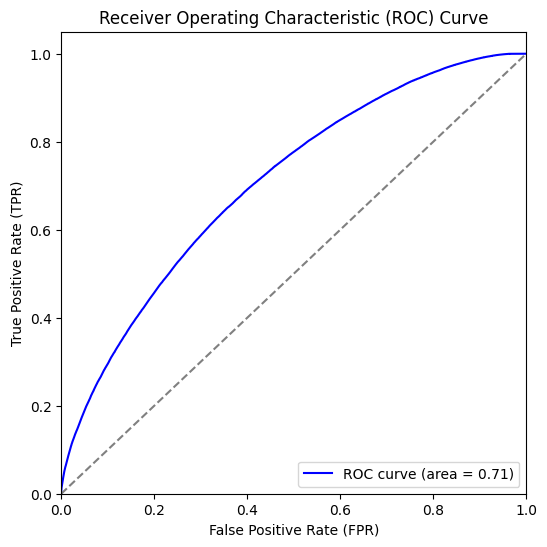

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 모델 예측 (확률값)
y_pred_proba = model.predict(X_test)

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 가설 변경한 피처 반영


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from joblib import parallel_backend

# 데이터 불러오기
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

# 유저 정보 병합
train = train.merge(orders[['order_id', 'user_id']], on='order_id', how='left')

# 제품별 재구매율
product_reordered_rate = train.groupby('product_id')['reordered'].mean().reset_index()
product_reordered_rate.columns = ['product_id', 'product_reorder_rate']

# 유저별 총 주문 수 + 전체 reorder 비율
user_orders = orders.groupby('user_id')['order_number'].max().reset_index()
user_orders.columns = ['user_id', 'user_total_orders']

user_reorders = train.groupby('user_id')['reordered'].mean().reset_index()
user_reorders.columns = ['user_id', 'user_reorder_ratio']

# 유저 피처 결합
user_features = pd.merge(user_orders, user_reorders, on='user_id', how='left')

# 제품 + 유저 피처를 train에 merge
train_data = train.merge(product_reordered_rate, on='product_id', how='left')
train_data = train_data.merge(user_features, on='user_id', how='left')

# 제품별 재구매율 변화량 (rolling)
train_data['product_reorder_rate_change'] = train_data.groupby('product_id')['reordered'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean().diff().fillna(0)
)

# 훈련 셋 구성하기
train_data = train_data[['order_id', 'product_id', 'add_to_cart_order',
                         'product_reorder_rate', 'product_reorder_rate_change',
                         'user_total_orders', 'user_reorder_ratio', 'reordered']]

In [ ]:
# 결측 제거 및 불필요 컬럼 제거
original_data = train_data.copy()
original_data.dropna(inplace=True)
original_data.drop(columns=['order_id', 'product_id'], inplace=True)

# 스케일링
scaler = MinMaxScaler()
scale_cols = ['add_to_cart_order', 'user_total_orders']
original_data[scale_cols] = scaler.fit_transform(original_data[scale_cols])

In [ ]:
# X, y 분리
X = original_data.drop('reordered', axis=1)
y = original_data['reordered']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Validation: {y_val.shape}, Test: {y_test.shape}")

Train: (830769, 5), Validation: (276924, 5), Test: (276924, 5)
Train: (830769,), Validation: (276924,), Test: (276924,)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
import pandas as pd
import os
import random
import numpy as np
import tensorflow as tf
import re

# 시드 고정

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

model = keras.Sequential([
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(164, activation='relu'),
    layers.Dropout(0.3),
    BatchNormalization(),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    BatchNormalization(),

    layers.Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['acc']
)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/100
25962/25962 ━━━━━━━━━━━━━━━━━━━━ 98s 4ms/step - acc: 0.9063 - loss: 0.2161 - val_acc: 0.9192 - val_loss: 0.1826
Epoch 2/100
25962/25962 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - acc: 0.9157 - loss: 0.1949 - val_acc: 0.9188 - val_loss: 0.1799
Epoch 3/100
25962/25962 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - acc: 0.9163 - loss: 0.1914 - val_acc: 0.9193 - val_loss: 0.1808
Epoch 4/100
25962/25962 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - acc: 0.9166 - loss: 0.1904 - val_acc: 0.9182 - val_loss: 0.1848
Epoch 5/100
25962/25962 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - acc: 0.9166 - loss: 0.1903 - val_acc: 0.9198 - val_loss: 0.1814
Epoch 6/100
25962/25962 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/step - acc: 0.9167 - loss: 0.1904 - val_acc: 0.9167 - val_loss: 0.2482
Epoch 7/100
25962/25962 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - acc: 0.9172 - loss: 0.1898 - val_acc: 0.9189 - val_loss: 0.1833


In [ ]:
pred_prob = model.predict(X_test)
pred = (pred_prob>0.5).astype(int)
score = classification_report(y_test, pred, output_dict=True)
pd.DataFrame(score).T

8654/8654 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


,precision,recall,f1-score,support
0,0.902384,0.897822,0.900097,111159.00
1,0.931713,0.934872,0.933290,165765.00
accuracy,0.920000,0.920000,0.920000,0.92
macro avg,0.917049,0.916347,0.916693,276924.00
weighted avg,0.919940,0.920000,0.919966,276924.00


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
acc = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f'accuracy: {round(acc, 2)}')
print(f'precision: {round(precision, 2)}')
print(f'recall: {round(recall, 2)}')
print(f'f1: {round(f1, 2)}')

accuracy: 0.92
precision: 0.93
recall: 0.93
f1: 0.93


8654/8654 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


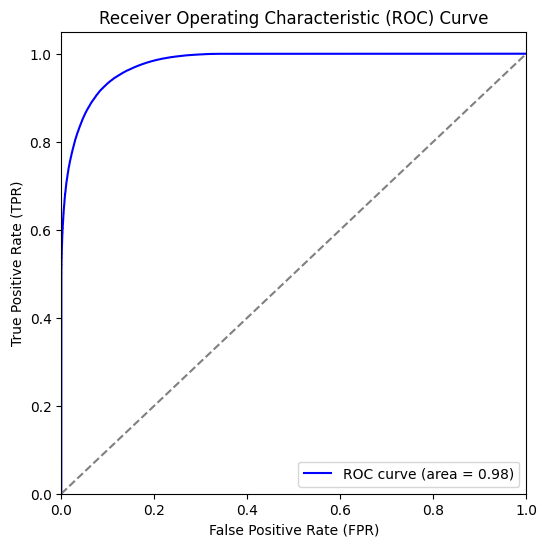

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 모델 예측 (확률값)
y_pred_proba = model.predict(X_test)

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()